# Task 1

In [ ]:
from torch.utils.data import Dataset
import numpy as np

In [ ]:
class LettersDataSet(Dataset):
  """LettersDataSet class."""
  def __init__(self, labels_file: str, images_file: str, transform=None, target_transform=None):
    # data loading
    with open(images_file, 'rb') as f:
      self.num = int.from_bytes(f.read(4), 'big')
      rows = int.from_bytes(f.read(4), 'big')
      cols = int.from_bytes(f.read(4), 'big')
    self.images = np.fromfile(images_file, dtype=np.dtype((np.uint8, (rows,cols))), offset=12)
    self.labels = np.fromfile(labels_file, dtype='B', offset=4)
    self.transform = transform
    self.target_transform = target_transform

  def __getitem__(self, index):
    # dataset[0]
    image = self.transform(self.images[index]) if self.transform else self.images[index]
    label = self.target_transform(self.labels[index]) if self.target_transform else self.labels[index]
    return {'image': image, 'label': label}

  def __len__(self):
    # len(dataset)
    return self.num

In [ ]:
dataset = LettersDataSet('/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-train-labels-idx1-ubyte',
                         '/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-train-images-idx3-ubyte')

# Task 2

In [ ]:
import matplotlib.pyplot as plt

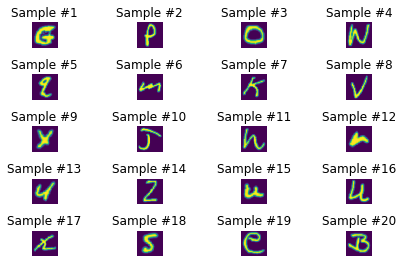

In [ ]:
fig = plt.figure()

for i in range(1, 21):
  sample = dataset[i]
  ax = plt.subplot(5, 4, i)
  plt.tight_layout()
  ax.set_title(f"Sample #{i}")
  ax.axis('off')
  plt.imshow(np.transpose(sample['image']))

plt.show()

# Task 3

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
from datetime import datetime 

In [ ]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 26
N_EPOCHS = 15

IMG_SIZE = 28
N_CLASSES = 26

## Helper function

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for loader in data_loader:
          X = loader['image']
          y_true = loader['label']
          X = X.to(device)
          y_true = y_true.to(device)

          _, y_prob = model(X)
          _, predicted_labels = torch.max(y_prob, 1)

          n += y_true.size(0)
          correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for loader in train_loader:
      X = loader['image']
      y_true = loader['label']

      optimizer.zero_grad()
      
      X = X.to(device)
      y_true = y_true.to(device)
  
      # Forward pass
      y_hat, _ = model(X) 
      loss = criterion(y_hat, y_true) 
      running_loss += loss.item() * X.size(0)

      # Backward pass
      loss.backward()
      optimizer.step()
      
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for loader in valid_loader:
      X = loader['image']
      y_true = loader['label']
      X = X.to(device)
      y_true = y_true.to(device)

      # Forward pass and record loss
      y_hat, _ = model(X) 
      loss = criterion(y_hat, y_true) 
      running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

      # training
      model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
      train_losses.append(train_loss)

      # validation
      with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, device)
        valid_losses.append(valid_loss)

      if epoch % print_every == (print_every - 1):
          
        train_acc = get_accuracy(model, train_loader, device=device)
        valid_acc = get_accuracy(model, valid_loader, device=device)
            
        print(f'{datetime.now().time().replace(microsecond=0)} --- '
              f'Epoch: {epoch}\t'
              f'Train loss: {train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Train accuracy: {100 * train_acc:.2f}\t'
              f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
trfms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((28, 28)), torchvision.transforms.ToTensor()])
target_trfms = torchvision.transforms.Lambda(lambda x: x-1)
train_dataset = LettersDataSet('/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-train-labels-idx1-ubyte',
                         '/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-train-images-idx3-ubyte', transform=trfms, target_transform=target_trfms)
test_dataset = LettersDataSet('/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-test-labels-idx1-ubyte',
                         '/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-test-images-idx3-ubyte', transform=trfms, target_transform=target_trfms)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1), # 6x26x26 (4056)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # 6x13x13 (1014)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1), # 16x10x10 (1600)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # 16x5x5 (400)
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1), # 120x3x3 (1080)
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1080, out_features=100),
            nn.Tanh(),
            nn.Linear(in_features=100, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
DEVICE = 'cpu'

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Using CPU training took 1690.784s (~28 min)

07:08:12 --- Epoch: 0	Train loss: 0.3114	Valid loss: 0.3149	Train accuracy: 90.91	Valid accuracy: 90.18
07:10:06 --- Epoch: 1	Train loss: 0.2865	Valid loss: 0.3005	Train accuracy: 91.33	Valid accuracy: 90.36
07:11:58 --- Epoch: 2	Train loss: 0.2681	Valid loss: 0.2886	Train accuracy: 91.59	Valid accuracy: 90.73
07:13:50 --- Epoch: 3	Train loss: 0.2568	Valid loss: 0.2855	Train accuracy: 92.23	Valid accuracy: 91.12
07:15:43 --- Epoch: 4	Train loss: 0.2464	Valid loss: 0.2818	Train accuracy: 92.28	Valid accuracy: 91.03
07:17:37 --- Epoch: 5	Train loss: 0.2392	Valid loss: 0.2745	Train accuracy: 92.65	Valid accuracy: 91.46
07:19:30 --- Epoch: 6	Train loss: 0.2326	Valid loss: 0.2807	Train accuracy: 92.47	Valid accuracy: 91.20
07:21:24 --- Epoch: 7	Train loss: 0.2251	Valid loss: 0.2718	Train accuracy: 92.77	Valid accuracy: 91.42
07:23:17 --- Epoch: 8	Train loss: 0.2190	Valid loss: 0.2646	Train accuracy: 93.20	Valid accuracy: 91.70
07:25:11 --- Epoch: 9	Train loss: 0.2173	Valid loss: 0.2706	Trai

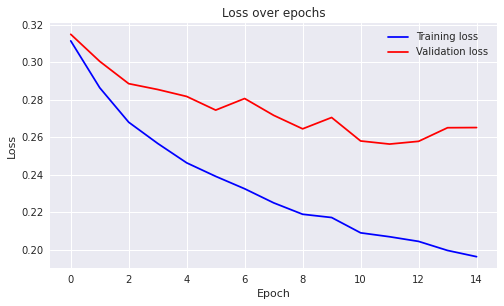

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE)

# Task 4

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
model_gpu = LeNet5(N_CLASSES).to(DEVICE)
optimizer_gpu = torch.optim.Adam(model_gpu.parameters(), lr=LEARNING_RATE)
criterion_gpu = nn.CrossEntropyLoss()

cuda


Using GPU training took 901.647s (~15 min), a 53.33% speedup

07:55:50 --- Epoch: 0	Train loss: 0.6484	Valid loss: 0.4131	Train accuracy: 87.55	Valid accuracy: 86.90
07:56:50 --- Epoch: 1	Train loss: 0.3478	Valid loss: 0.3333	Train accuracy: 90.16	Valid accuracy: 89.49
07:57:50 --- Epoch: 2	Train loss: 0.3025	Valid loss: 0.3025	Train accuracy: 91.30	Valid accuracy: 90.25
07:58:50 --- Epoch: 3	Train loss: 0.2790	Valid loss: 0.2981	Train accuracy: 91.58	Valid accuracy: 90.63
07:59:50 --- Epoch: 4	Train loss: 0.2639	Valid loss: 0.2890	Train accuracy: 92.13	Valid accuracy: 91.04
08:00:50 --- Epoch: 5	Train loss: 0.2558	Valid loss: 0.2872	Train accuracy: 92.19	Valid accuracy: 91.00
08:01:49 --- Epoch: 6	Train loss: 0.2453	Valid loss: 0.2781	Train accuracy: 92.24	Valid accuracy: 91.17
08:02:49 --- Epoch: 7	Train loss: 0.2389	Valid loss: 0.2756	Train accuracy: 92.63	Valid accuracy: 91.31
08:03:48 --- Epoch: 8	Train loss: 0.2296	Valid loss: 0.2760	Train accuracy: 92.82	Valid accuracy: 91.56
08:04:47 --- Epoch: 9	Train loss: 0.2274	Valid loss: 0.2843	Trai

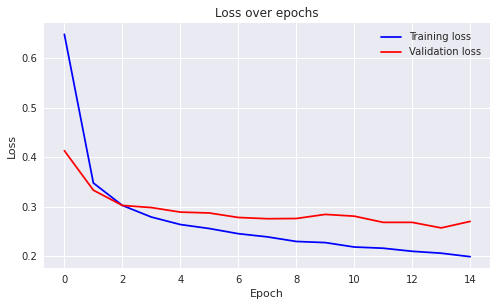

In [ ]:
model_gpu, optimizer_gpu, _ = training_loop(model_gpu, criterion_gpu, optimizer_gpu, train_loader, test_loader, N_EPOCHS, DEVICE)